In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Import data

In [2]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


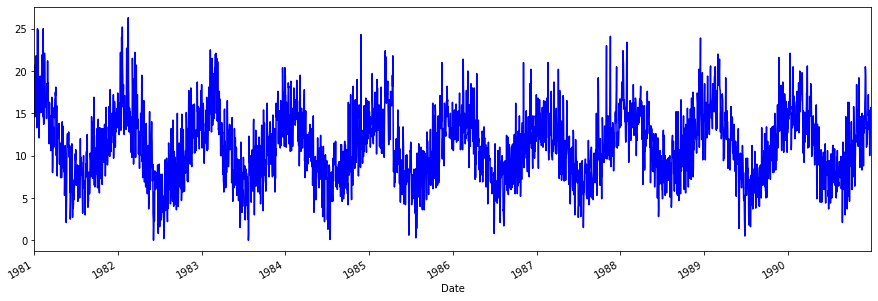

In [3]:
df.Temp.plot(figsize=(15, 5), color='b')

## Dataset Splitting

In [4]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape,ts_test.shape

((2920, 1), (730, 1))

## Dataset & Dataloader

In [5]:
from torch.utils.data import TensorDataset, DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [6]:
bs = 32
seq_len = 14

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs, num_workers=4)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



## Arsitektur & Config

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layer, dropout, batch_first=True):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layer, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden
        

In [8]:
config = set_config({
    "input_size": 1,
    "output_size": 1,
    "seq_len": 14,
    "bs": 32,
    "hidden_size": 64,
    "num_layer": 2,
    "drop_out": 0
})

## Training Preparation => MCOC

In [9]:
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layer, config.drop_out).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/rnn")

## Training

In [10]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 122.7141 | Test_cost  = 109.9353 | 




Epoch     2
Train_cost  = 92.7177 | Test_cost  = 85.4162 | 




Epoch     3
Train_cost  = 72.9146 | Test_cost  = 70.3378 | 




Epoch     4
Train_cost  = 60.8356 | Test_cost  = 60.6194 | 




Epoch     5
Train_cost  = 52.7905 | Test_cost  = 53.6774 | 




Epoch     6
Train_cost  = 46.8224 | Test_cost  = 48.0714 | 




Epoch     7
Train_cost  = 41.8851 | Test_cost  = 43.2585 | 




Epoch     8
Train_cost  = 37.6394 | Test_cost  = 39.0557 | 




Epoch     9
Train_cost  = 33.9469 | Test_cost  = 35.3690 | 




Epoch    10
Train_cost  = 30.7435 | Test_cost  = 32.1762 | 




Epoch    11
Train_cost  = 28.0144 | Test_cost  = 29.4609 | 




Epoch    12
Train_cost  = 25.7259 | Test_cost  = 27.1737 | 




Epoch    13
Train_cost  = 23.8255 | Test_cost  = 25.2609 | 




Epoch    14
Train_cost  = 22.2610 | Test_cost  = 23.6720 | 




Epoch    15
Train_cost  = 20.9837 | Test_cost  = 22.3604 | 




Epoch    16
Train_cost  = 19.9495 | Test_cost  = 21.2842 | 




Epoch    17
Train_cost  = 19.1190 | Test_cost  = 20.4061 | 




Epoch    18
Train_cost  = 18.4578 | Test_cost  = 19.6936 | 




Epoch    19
Train_cost  = 17.9356 | Test_cost  = 19.1182 | 




Epoch    20
Train_cost  = 17.5266 | Test_cost  = 18.6557 | 


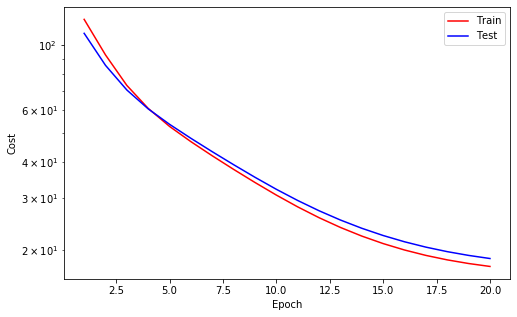



Epoch    21
Train_cost  = 17.2090 | Test_cost  = 18.2854 | 




Epoch    22
Train_cost  = 16.9641 | Test_cost  = 17.9898 | 




Epoch    23
Train_cost  = 16.7768 | Test_cost  = 17.7545 | 




Epoch    24
Train_cost  = 16.6344 | Test_cost  = 17.5674 | 




Epoch    25
Train_cost  = 16.5268 | Test_cost  = 17.4188 | 




Epoch    26
Train_cost  = 16.4459 | Test_cost  = 17.3006 | 




Epoch    27
Train_cost  = 16.3851 | Test_cost  = 17.2065 | 




Epoch    28
Train_cost  = 16.3393 | Test_cost  = 17.1314 | 




Epoch    29
Train_cost  = 16.3047 | Test_cost  = 17.0710 | 




Epoch    30
Train_cost  = 16.2782 | Test_cost  = 17.0223 | 




Epoch    31
Train_cost  = 16.2573 | Test_cost  = 16.9824 | 




Epoch    32
Train_cost  = 16.2404 | Test_cost  = 16.9493 | 




Epoch    33
Train_cost  = 16.2258 | Test_cost  = 16.9211 | 




Epoch    34
Train_cost  = 16.2122 | Test_cost  = 16.8960 | 




Epoch    35
Train_cost  = 16.1983 | Test_cost  = 16.8723 | 




Epoch    36
Train_cost  = 16.1820 | Test_cost  = 16.8469 | 




Epoch    37
Train_cost  = 16.1592 | Test_cost  = 16.8124 | 




Epoch    38
Train_cost  = 16.1147 | Test_cost  = 16.7344 | 




Epoch    39
Train_cost  = 15.9622 | Test_cost  = 16.4994 | 




Epoch    40
Train_cost  = 15.7067 | Test_cost  = 16.3419 | 


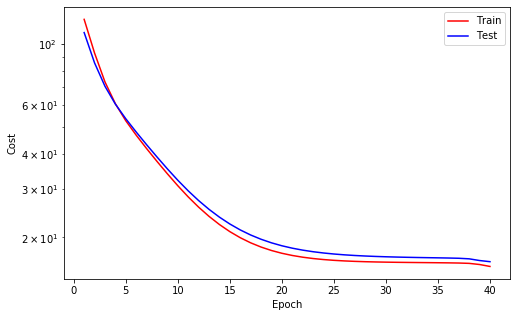



Epoch    41
Train_cost  = 15.4126 | Test_cost  = 15.8158 | 




Epoch    42
Train_cost  = 14.8024 | Test_cost  = 14.8244 | 




Epoch    43
Train_cost  = 13.6193 | Test_cost  = 13.8437 | 




Epoch    44
Train_cost  = 12.9375 | Test_cost  = 13.2108 | 




Epoch    45
Train_cost  = 12.2485 | Test_cost  = 12.2734 | 




Epoch    46
Train_cost  = 11.5930 | Test_cost  = 11.6338 | 




Epoch    47
Train_cost  = 11.1306 | Test_cost  = 11.0840 | 




Epoch    48
Train_cost  = 10.6816 | Test_cost  = 10.6149 | 




Epoch    49
Train_cost  = 10.2879 | Test_cost  = 10.1817 | 




Epoch    50
Train_cost  = 9.9434 | Test_cost  = 9.7741 | 




Epoch    51
Train_cost  = 9.6469 | Test_cost  = 9.4161 | 




Epoch    52
Train_cost  = 9.4022 | Test_cost  = 9.1114 | 




Epoch    53
Train_cost  = 9.1907 | Test_cost  = 8.8420 | 




Epoch    54
Train_cost  = 8.9908 | Test_cost  = 8.6021 | 




Epoch    55
Train_cost  = 8.8078 | Test_cost  = 8.3913 | 




Epoch    56
Train_cost  = 8.6519 | Test_cost  = 8.2021 | 




Epoch    57
Train_cost  = 8.5133 | Test_cost  = 8.0239 | 




Epoch    58
Train_cost  = 8.3782 | Test_cost  = 7.8574 | 




Epoch    59
Train_cost  = 8.2467 | Test_cost  = 7.7040 | 




Epoch    60
Train_cost  = 8.1252 | Test_cost  = 7.5617 | 


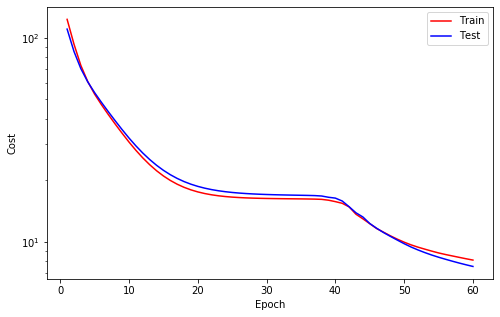



Epoch    61
Train_cost  = 8.0133 | Test_cost  = 7.4290 | 




Epoch    62
Train_cost  = 7.9087 | Test_cost  = 7.3065 | 




Epoch    63
Train_cost  = 7.8119 | Test_cost  = 7.1942 | 




Epoch    64
Train_cost  = 7.7243 | Test_cost  = 7.0907 | 




Epoch    65
Train_cost  = 7.6454 | Test_cost  = 6.9951 | 




Epoch    66
Train_cost  = 7.5729 | Test_cost  = 6.9064 | 




Epoch    67
Train_cost  = 7.5055 | Test_cost  = 6.8237 | 




Epoch    68
Train_cost  = 7.4425 | Test_cost  = 6.7465 | 




Epoch    69
Train_cost  = 7.3837 | Test_cost  = 6.6746 | 




Epoch    70
Train_cost  = 7.3289 | Test_cost  = 6.6076 | 




Epoch    71
Train_cost  = 7.2777 | Test_cost  = 6.5451 | 




Epoch    72
Train_cost  = 7.2297 | Test_cost  = 6.4868 | 




Epoch    73
Train_cost  = 7.1845 | Test_cost  = 6.4323 | 




Epoch    74
Train_cost  = 7.1420 | Test_cost  = 6.3813 | 




Epoch    75
Train_cost  = 7.1018 | Test_cost  = 6.3336 | 




Epoch    76
Train_cost  = 7.0638 | Test_cost  = 6.2887 | 




Epoch    77
Train_cost  = 7.0279 | Test_cost  = 6.2465 | 




Epoch    78
Train_cost  = 6.9938 | Test_cost  = 6.2067 | 




Epoch    79
Train_cost  = 6.9615 | Test_cost  = 6.1691 | 




Epoch    80
Train_cost  = 6.9308 | Test_cost  = 6.1337 | 


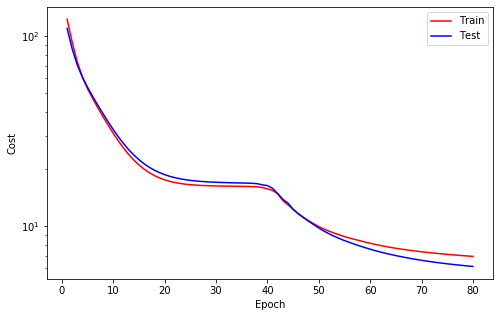



Epoch    81
Train_cost  = 6.9015 | Test_cost  = 6.1002 | 




Epoch    82
Train_cost  = 6.8737 | Test_cost  = 6.0684 | 




Epoch    83
Train_cost  = 6.8472 | Test_cost  = 6.0383 | 




Epoch    84
Train_cost  = 6.8220 | Test_cost  = 6.0098 | 




Epoch    85
Train_cost  = 6.7980 | Test_cost  = 5.9827 | 




Epoch    86
Train_cost  = 6.7751 | Test_cost  = 5.9569 | 




Epoch    87
Train_cost  = 6.7532 | Test_cost  = 5.9323 | 




Epoch    88
Train_cost  = 6.7323 | Test_cost  = 5.9089 | 




Epoch    89
Train_cost  = 6.7123 | Test_cost  = 5.8866 | 




Epoch    90
Train_cost  = 6.6933 | Test_cost  = 5.8653 | 




Epoch    91
Train_cost  = 6.6750 | Test_cost  = 5.8449 | 




Epoch    92
Train_cost  = 6.6575 | Test_cost  = 5.8254 | 




Epoch    93
Train_cost  = 6.6406 | Test_cost  = 5.8067 | 




Epoch    94
Train_cost  = 6.6245 | Test_cost  = 5.7887 | 




Epoch    95
Train_cost  = 6.6089 | Test_cost  = 5.7715 | 




Epoch    96
Train_cost  = 6.5939 | Test_cost  = 5.7549 | 




Epoch    97
Train_cost  = 6.5795 | Test_cost  = 5.7390 | 




Epoch    98
Train_cost  = 6.5655 | Test_cost  = 5.7237 | 




Epoch    99
Train_cost  = 6.5521 | Test_cost  = 5.7089 | 




Epoch   100
Train_cost  = 6.5391 | Test_cost  = 5.6947 | 


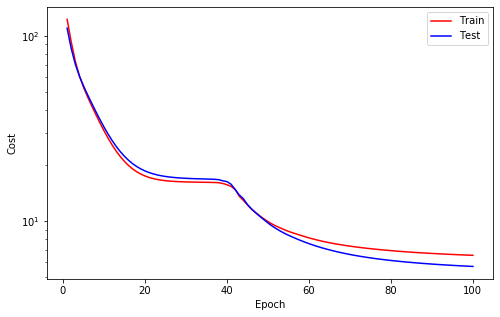



Epoch   101
Train_cost  = 6.5265 | Test_cost  = 5.6810 | 




Epoch   102
Train_cost  = 6.5143 | Test_cost  = 5.6678 | 




Epoch   103
Train_cost  = 6.5025 | Test_cost  = 5.6550 | 




Epoch   104
Train_cost  = 6.4911 | Test_cost  = 5.6427 | 




Epoch   105
Train_cost  = 6.4800 | Test_cost  = 5.6308 | 




Epoch   106
Train_cost  = 6.4693 | Test_cost  = 5.6192 | 




Epoch   107
Train_cost  = 6.4589 | Test_cost  = 5.6081 | 




Epoch   108
Train_cost  = 6.4487 | Test_cost  = 5.5973 | 




Epoch   109
Train_cost  = 6.4389 | Test_cost  = 5.5868 | 




Epoch   110
Train_cost  = 6.4293 | Test_cost  = 5.5767 | 




Epoch   111
Train_cost  = 6.4200 | Test_cost  = 5.5669 | 




Epoch   112
Train_cost  = 6.4110 | Test_cost  = 5.5574 | 




Epoch   113
Train_cost  = 6.4021 | Test_cost  = 5.5482 | 




Epoch   114
Train_cost  = 6.3935 | Test_cost  = 5.5392 | 




Epoch   115
Train_cost  = 6.3852 | Test_cost  = 5.5305 | 




Epoch   116
Train_cost  = 6.3770 | Test_cost  = 5.5221 | 




Epoch   117
Train_cost  = 6.3690 | Test_cost  = 5.5139 | 




Epoch   118
Train_cost  = 6.3612 | Test_cost  = 5.5059 | 




Epoch   119
Train_cost  = 6.3536 | Test_cost  = 5.4981 | 




Epoch   120
Train_cost  = 6.3461 | Test_cost  = 5.4906 | 


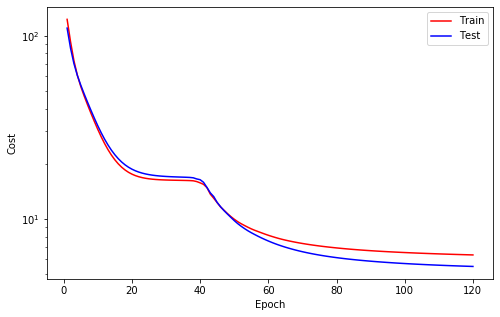



Epoch   121
Train_cost  = 6.3388 | Test_cost  = 5.4832 | 




Epoch   122
Train_cost  = 6.3316 | Test_cost  = 5.4760 | 




Epoch   123
Train_cost  = 6.3246 | Test_cost  = 5.4690 | 




Epoch   124
Train_cost  = 6.3177 | Test_cost  = 5.4622 | 




Epoch   125
Train_cost  = 6.3109 | Test_cost  = 5.4556 | 




Epoch   126
Train_cost  = 6.3042 | Test_cost  = 5.4491 | 




Epoch   127
Train_cost  = 6.2976 | Test_cost  = 5.4429 | 




Epoch   128
Train_cost  = 6.2912 | Test_cost  = 5.4368 | 




Epoch   129
Train_cost  = 6.2848 | Test_cost  = 5.4308 | 




Epoch   130
Train_cost  = 6.2786 | Test_cost  = 5.4251 | 




Epoch   131
Train_cost  = 6.2724 | Test_cost  = 5.4195 | 




Epoch   132
Train_cost  = 6.2664 | Test_cost  = 5.4140 | 




Epoch   133
Train_cost  = 6.2605 | Test_cost  = 5.4087 | 




Epoch   134
Train_cost  = 6.2546 | Test_cost  = 5.4036 | 




Epoch   135
Train_cost  = 6.2489 | Test_cost  = 5.3986 | 




Epoch   136
Train_cost  = 6.2432 | Test_cost  = 5.3937 | 




Epoch   137
Train_cost  = 6.2377 | Test_cost  = 5.3890 | 




Epoch   138
Train_cost  = 6.2322 | Test_cost  = 5.3844 | 




Epoch   139
Train_cost  = 6.2268 | Test_cost  = 5.3799 | 




Epoch   140
Train_cost  = 6.2215 | Test_cost  = 5.3755 | 


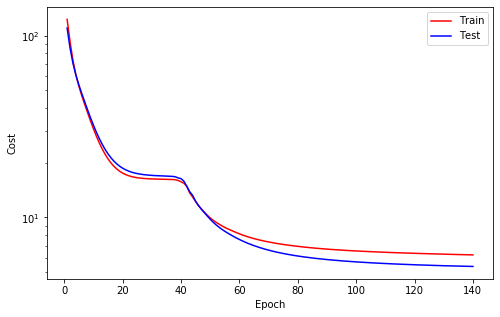



Epoch   141
Train_cost  = 6.2162 | Test_cost  = 5.3713 | 




Epoch   142
Train_cost  = 6.2110 | Test_cost  = 5.3671 | 




Epoch   143
Train_cost  = 6.2059 | Test_cost  = 5.3631 | 




Epoch   144
Train_cost  = 6.2008 | Test_cost  = 5.3592 | 




Epoch   145
Train_cost  = 6.1958 | Test_cost  = 5.3554 | 




Epoch   146
Train_cost  = 6.1909 | Test_cost  = 5.3517 | 




Epoch   147
Train_cost  = 6.1860 | Test_cost  = 5.3480 | 




Epoch   148
Train_cost  = 6.1811 | Test_cost  = 5.3445 | 




Epoch   149
Train_cost  = 6.1763 | Test_cost  = 5.3411 | 




Epoch   150
Train_cost  = 6.1715 | Test_cost  = 5.3378 | 




Epoch   151
Train_cost  = 6.1667 | Test_cost  = 5.3346 | 




Epoch   152
Train_cost  = 6.1619 | Test_cost  = 5.3315 | 




Epoch   153
Train_cost  = 6.1572 | Test_cost  = 5.3284 | 




Epoch   154
Train_cost  = 6.1525 | Test_cost  = 5.3255 | 




Epoch   155
Train_cost  = 6.1478 | Test_cost  = 5.3226 | 




Epoch   156
Train_cost  = 6.1431 | Test_cost  = 5.3199 | 




Epoch   157
Train_cost  = 6.1384 | Test_cost  = 5.3172 | 




Epoch   158
Train_cost  = 6.1337 | Test_cost  = 5.3146 | 




Epoch   159
Train_cost  = 6.1290 | Test_cost  = 5.3121 | 




Epoch   160
Train_cost  = 6.1242 | Test_cost  = 5.3097 | 


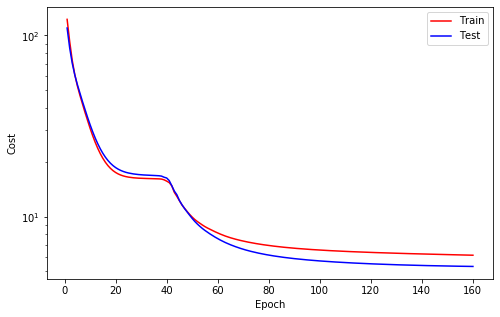



Epoch   161
Train_cost  = 6.1195 | Test_cost  = 5.3074 | 




Epoch   162
Train_cost  = 6.1147 | Test_cost  = 5.3051 | 




Epoch   163
Train_cost  = 6.1099 | Test_cost  = 5.3030 | 




Epoch   164
Train_cost  = 6.1050 | Test_cost  = 5.3009 | 




Epoch   165
Train_cost  = 6.1002 | Test_cost  = 5.2989 | 




Epoch   166
Train_cost  = 6.0952 | Test_cost  = 5.2969 | 




Epoch   167
Train_cost  = 6.0902 | Test_cost  = 5.2951 | 




Epoch   168
Train_cost  = 6.0852 | Test_cost  = 5.2933 | 




Epoch   169
Train_cost  = 6.0801 | Test_cost  = 5.2915 | 




Epoch   170
Train_cost  = 6.0750 | Test_cost  = 5.2899 | 




Epoch   171
Train_cost  = 6.0697 | Test_cost  = 5.2883 | 




Epoch   172
Train_cost  = 6.0644 | Test_cost  = 5.2867 | 




Epoch   173
Train_cost  = 6.0591 | Test_cost  = 5.2852 | 




Epoch   174
Train_cost  = 6.0536 | Test_cost  = 5.2838 | 




Epoch   175
Train_cost  = 6.0481 | Test_cost  = 5.2824 | 




Epoch   176
Train_cost  = 6.0425 | Test_cost  = 5.2811 | 




Epoch   177
Train_cost  = 6.0368 | Test_cost  = 5.2798 | 




Epoch   178
Train_cost  = 6.0310 | Test_cost  = 5.2786 | 




Epoch   179
Train_cost  = 6.0252 | Test_cost  = 5.2775 | 




Epoch   180
Train_cost  = 6.0193 | Test_cost  = 5.2764 | 


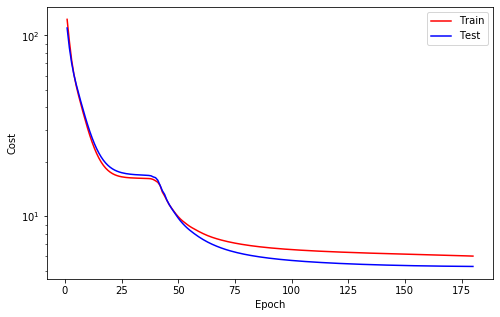



Epoch   181
Train_cost  = 6.0133 | Test_cost  = 5.2753 | 




Epoch   182
Train_cost  = 6.0073 | Test_cost  = 5.2744 | 




Epoch   183
Train_cost  = 6.0012 | Test_cost  = 5.2735 | 




Epoch   184
Train_cost  = 5.9951 | Test_cost  = 5.2727 | 




Epoch   185
Train_cost  = 5.9889 | Test_cost  = 5.2720 | 




Epoch   186
Train_cost  = 5.9826 | Test_cost  = 5.2714 | 




Epoch   187
Train_cost  = 5.9764 | Test_cost  = 5.2709 | 




Epoch   188
Train_cost  = 5.9700 | Test_cost  = 5.2705 | 




Epoch   189
Train_cost  = 5.9637 | Test_cost  = 5.2702 | 




Epoch   190
Train_cost  = 5.9573 | Test_cost  = 5.2700 | 




Epoch   191
Train_cost  = 5.9509 | Test_cost  = 5.2699 | 




Epoch   192
Train_cost  = 5.9444 | Test_cost  = 5.2700 | 
==> EarlyStop patience =  1 | Best test_cost: 5.2699




Epoch   193
Train_cost  = 5.9379 | Test_cost  = 5.2701 | 
==> EarlyStop patience =  2 | Best test_cost: 5.2699




Epoch   194
Train_cost  = 5.9314 | Test_cost  = 5.2704 | 
==> EarlyStop patience =  3 | Best test_cost: 5.2699




Epoch   195
Train_cost  = 5.9248 | Test_cost  = 5.2707 | 
==> EarlyStop patience =  4 | Best test_cost: 5.2699




Epoch   196
Train_cost  = 5.9183 | Test_cost  = 5.2712 | 
==> EarlyStop patience =  5 | Best test_cost: 5.2699
==> Execute Early Stopping at epoch: 196 | Best test_cost: 5.2699
==> Best model is saved at model/rnn


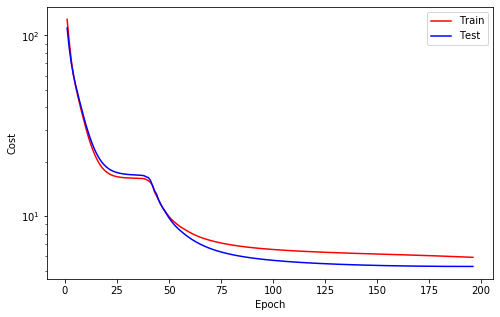

In [11]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Sanity Check

In [12]:
from luwiji.rnn import illustration

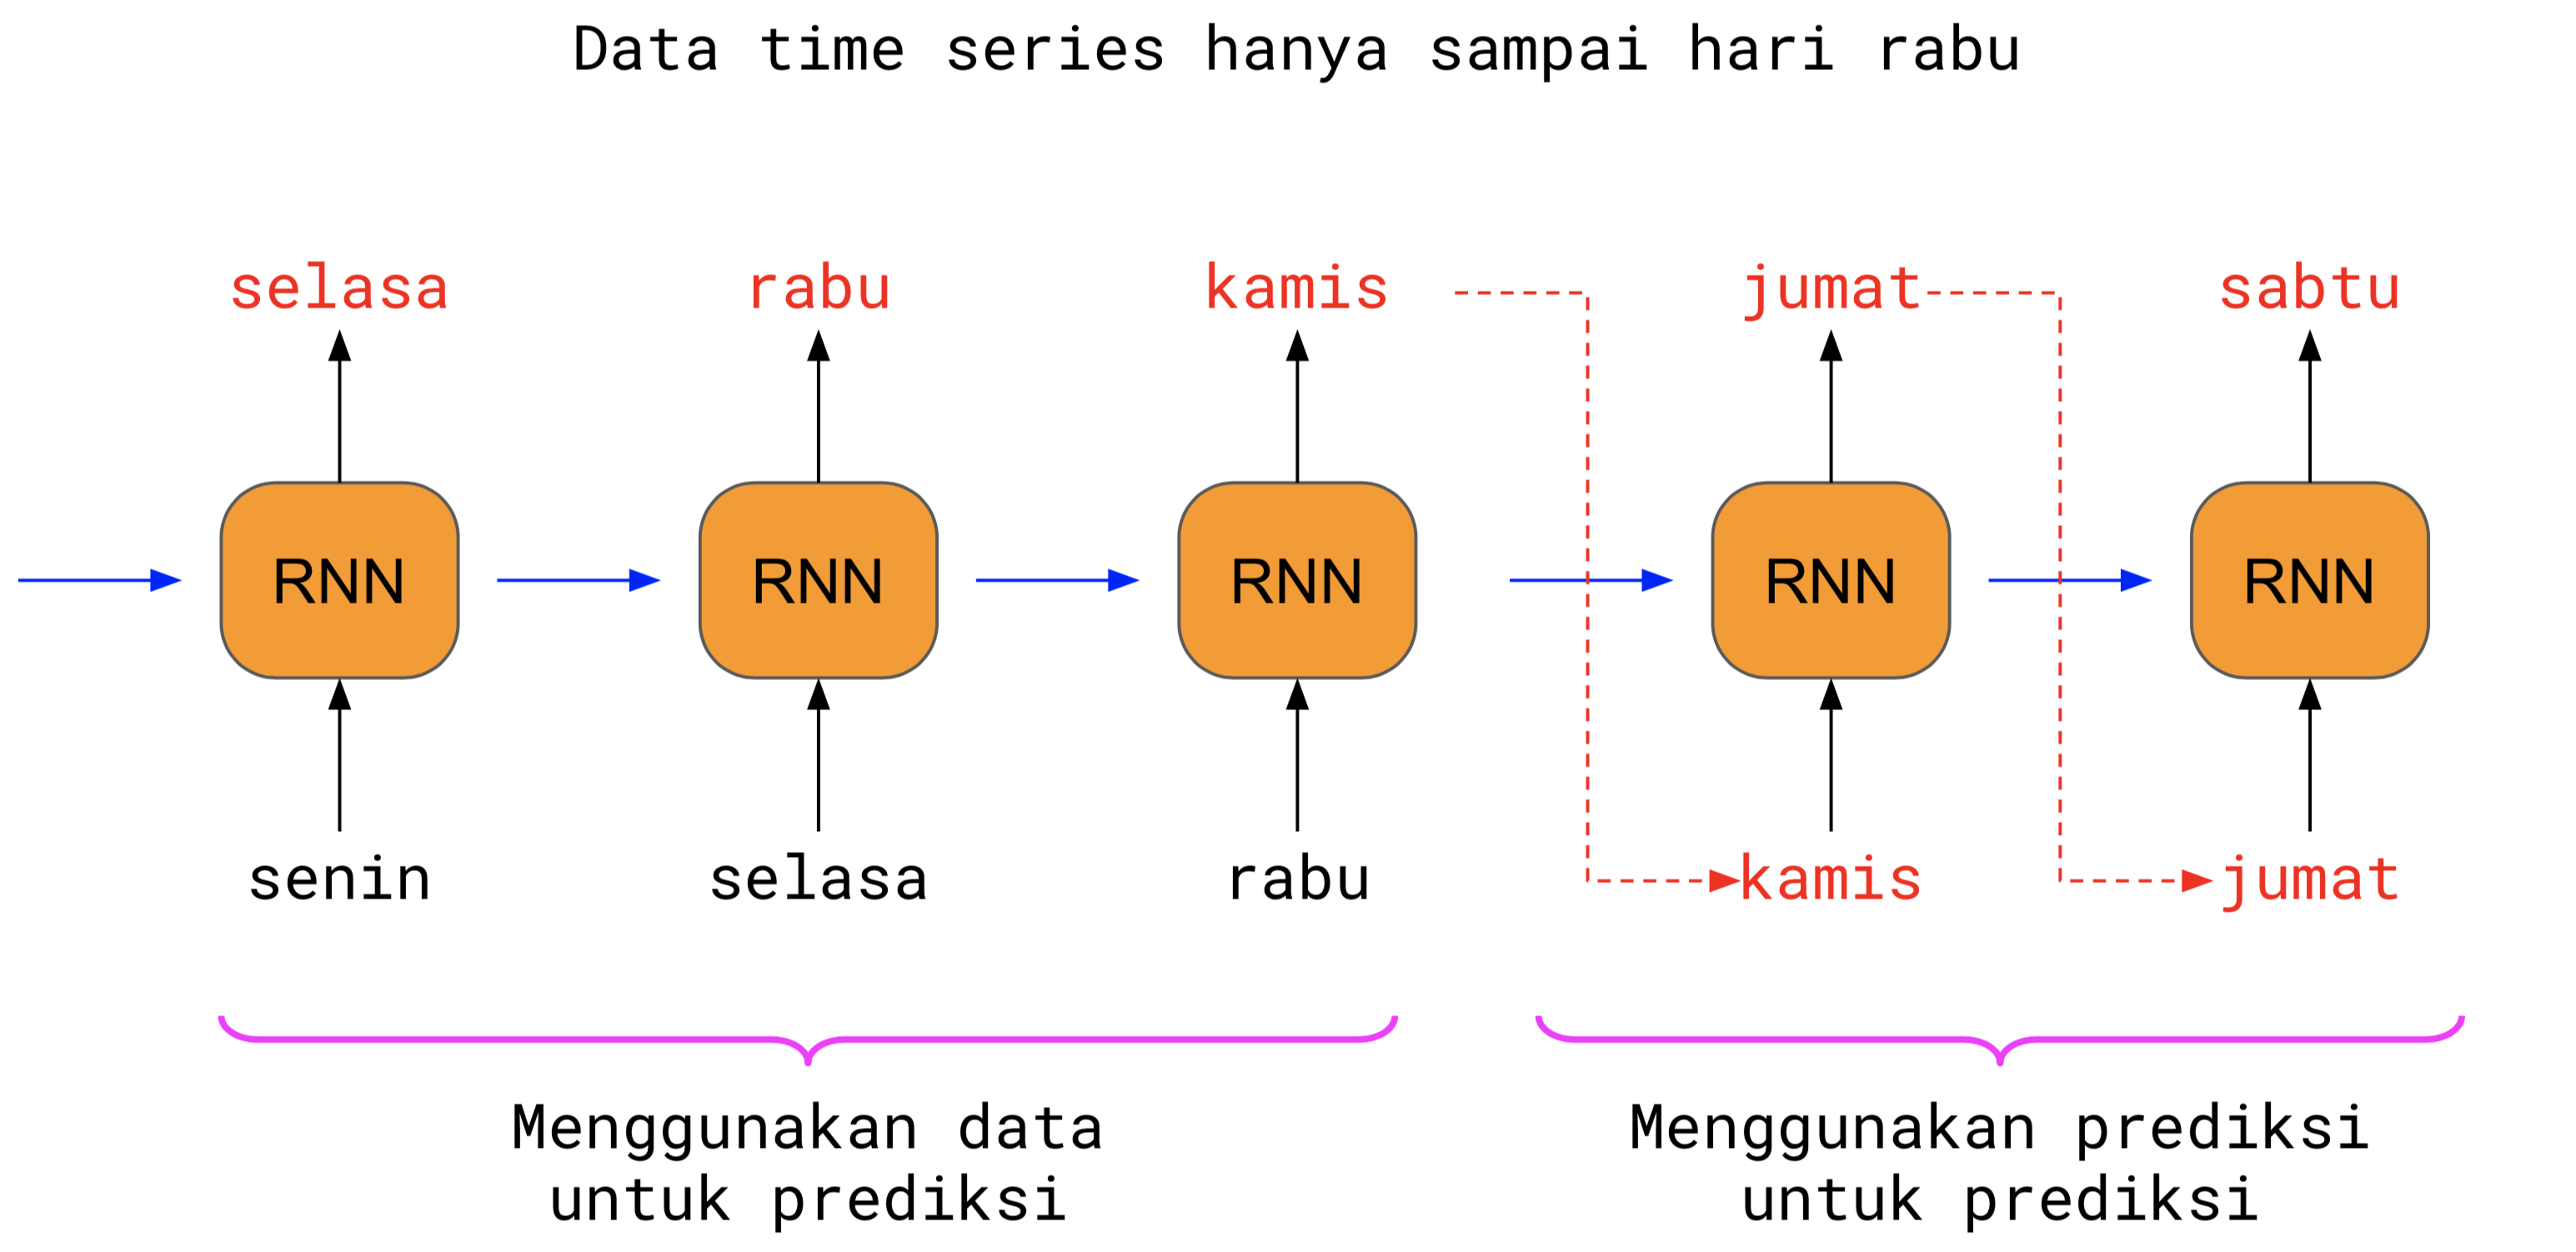

In [13]:
illustration.forecast

In [14]:
from utils import data4pred, pred4pred

In [15]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

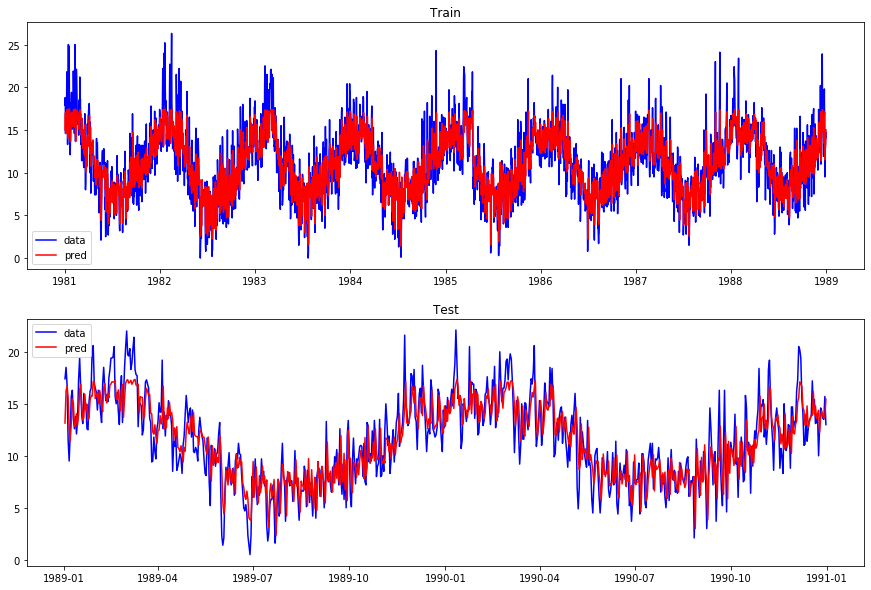

In [16]:
# Data for Pred
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'Test')

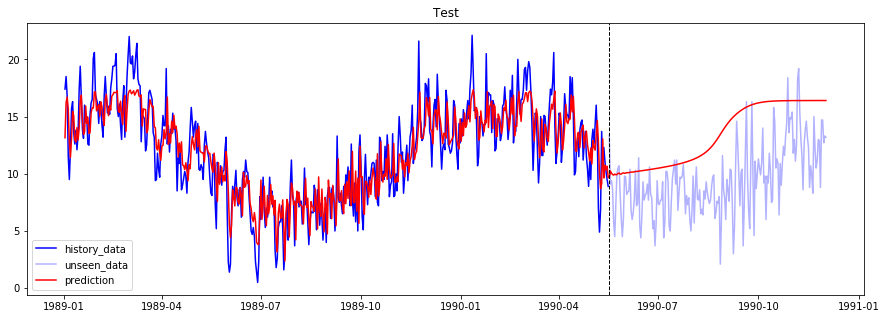

In [17]:
# Pred for Pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")